![表紙](https://www.oreilly.co.jp/books/images/picture978-4-87311-907-6.gif)

このノートブックはオライリー・ジャパンより発行の書籍[『セキュリティエンジニアのための機械学習』](https://www.oreilly.co.jp/books/9784873119076/)のサンプルコードです。コードの解説等は書籍をご参照ください。なお、このコードを動作させた結果について、著者およびオライリー・ジャパンは一切の責任を負いません。

In [ ]:
!wget https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch06/HostLogons-demo.csv

--2021-10-02 05:08:13--  https://raw.githubusercontent.com/oreilly-japan/ml-security-jp/master/ch06/HostLogons-demo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28128 (27K) [text/plain]
Saving to: ‘HostLogons-demo.csv’

HostLogons-demo.csv 100%[===================>]  27.47K  --.-KB/s    in 0.002s  

2021-10-02 05:08:13 (12.9 MB/s) - ‘HostLogons-demo.csv’ saved [28128/28128]



In [ ]:
import pandas as pd
# Date列にDateTime型を適用する
df = pd.read_csv('HostLogons-demo.csv', parse_dates=["Date"], infer_datetime_format=True)

In [ ]:
df

,Date,EventId,AccountNtdomain,ComputerName,logontype,TotalLogons
0,2018-01-03,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,10,2
1,2018-01-03,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,3,106
2,2018-01-03,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,4,68
3,2018-01-04,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,3,53
4,2018-01-04,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,4,89
...,...,...,...,...,...,...
343,2018-04-29,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,7,4
344,2018-04-30,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,10,1
345,2018-04-30,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,3,578
346,2018-04-30,Microsoft-Windows-Security-Auditing:4624,LABDOMAIN.LOCAL,WIN-DC01,4,53


In [ ]:
# Date列とComputerName列が同一の行のTotalLogons列をすべて加算して新たな行列にコピー
df_LogonSum = df.groupby(['Date','ComputerName'])['TotalLogons'].sum().reset_index()

# Date列とTotalLogons列のみを選択する
df_LogonSum = df_LogonSum[['Date','TotalLogons']]
df_LogonSum

,Date,TotalLogons
0,2018-01-03,176
1,2018-01-04,142
2,2018-01-05,85
3,2018-01-06,147
4,2018-01-07,142
...,...,...
113,2018-04-26,180
114,2018-04-27,98
115,2018-04-28,106
116,2018-04-29,322


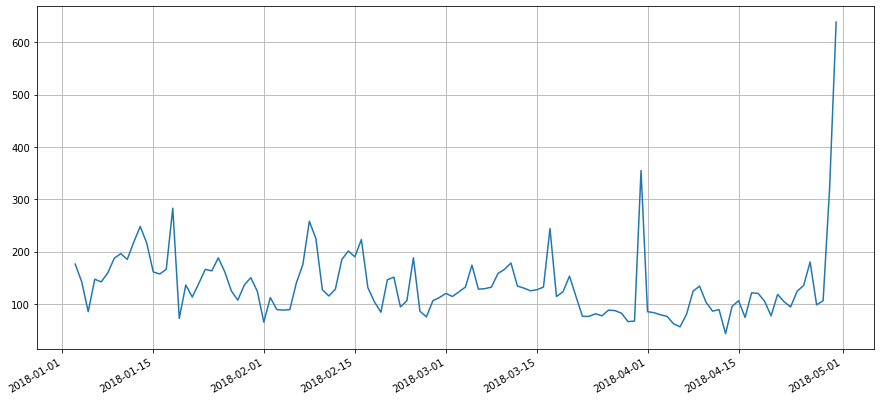

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
# オリジナルの時系列データの描画
ax.plot(df_LogonSum['Date'],df_LogonSum['TotalLogons'], label="original")

# X軸ラベルの調整
daysFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(daysFmt)
fig.autofmt_xdate()

plt.grid(True)

plt.show()

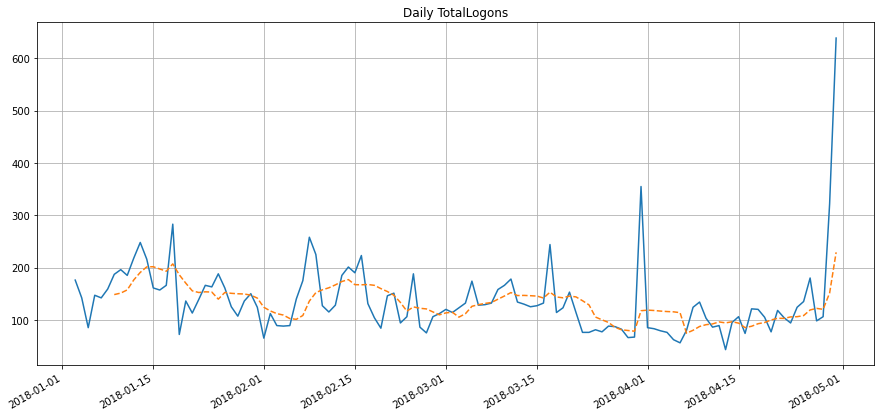

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
# 原系列データの描画
ax.plot(
    df_LogonSum['Date'],
    df_LogonSum['TotalLogons'], 
    label="original"
    )
# 7区間移動平均
ax.plot(
    df_LogonSum['Date'],
    df_LogonSum['TotalLogons'].rolling(7).mean(), 
    label="rolling", 
    ls="dashed"
    )
plt.title('Daily TotalLogons')

# X軸ラベルの調整
daysFmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(daysFmt)
fig.autofmt_xdate()

plt.grid(True)

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


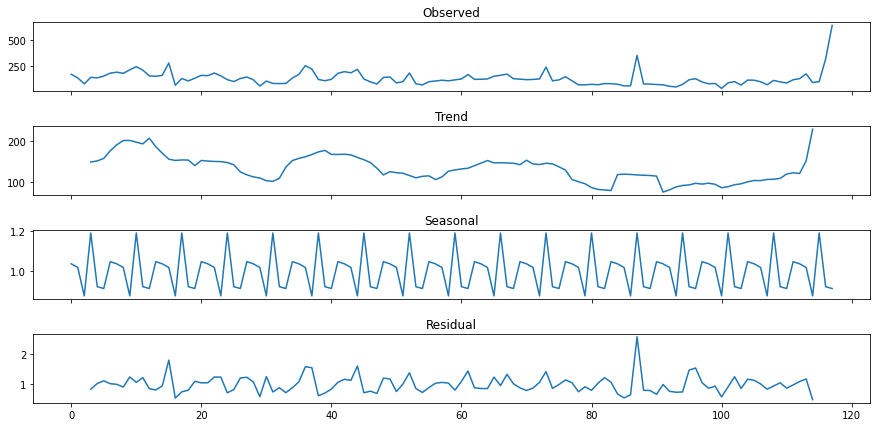

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# モデルにmultiplicativeを指定し、乗算モデルを使用する
result = seasonal_decompose(
    df_LogonSum['TotalLogons'], 
    model='multiplicative', 
    freq=7
    )

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 7), sharex=True)
plt.subplots_adjust(hspace=0.5)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(result.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(result.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(result.seasonal)

# 不規則変動
axes[3].set_title('Residual')
axes[3].plot(result.resid)

# グラフの表示
plt.show()

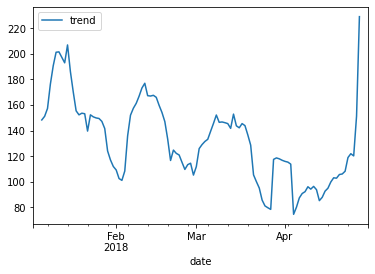

In [ ]:
trend = result.trend
trend = pd.DataFrame({'trend': trend, 'date':df_LogonSum.Date})
trend['date'] = pd.to_datetime(trend['date'], format='%Y-%m-%d')
trend = trend.set_index(['date'])
trend = trend.plot()

In [ ]:
from fbprophet import Prophet

def fit_predict_model(dataframe):
    model = Prophet(
        daily_seasonality = False, 
        weekly_seasonality = False, 
        yearly_seasonality = False,
        seasonality_mode = 'multiplicative',  # 乗法モデルを指定
        interval_width = 0.99, # 信頼区間の指定
        changepoint_range = 0.8 # 元データのうち80%を使って変化点検出を行う
        ) 
    # 月次の要素の季節性を追加
    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
        )
    model = model.fit(dataframe)
    
    # 予測の実施
    forecast = model.predict(dataframe)
    
    # 予測結果のデータフレームにfact列を新たに追加し、原系列データをコピー
    forecast['fact'] = dataframe['y'].reset_index(drop = True)

    # 予測値と原系列のグラフを出力
    fig1 = model.plot(forecast)
    return forecast


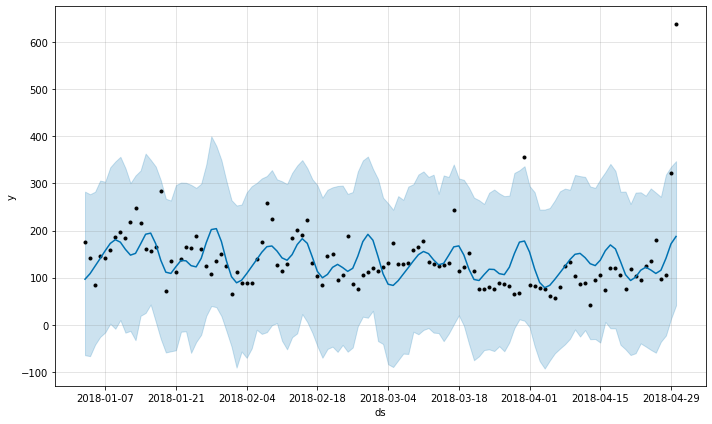

In [ ]:
# Prophet指定のカラム名に変更
df_LogonSum.columns = ['ds', 'y']

pred = fit_predict_model(df_LogonSum)

In [ ]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,fact
0,2018-01-03,153.601987,-64.548507,282.546793,153.601987,153.601987,-0.370217,-0.370217,-0.370217,-0.370217,-0.370217,-0.370217,0.0,0.0,0.0,96.735954,176
1,2018-01-04,153.257831,-66.514548,276.996703,153.257831,153.257831,-0.291992,-0.291992,-0.291992,-0.291992,-0.291992,-0.291992,0.0,0.0,0.0,108.507750,142
2,2018-01-05,152.913674,-42.170720,282.404996,152.913674,152.913674,-0.185006,-0.185006,-0.185006,-0.185006,-0.185006,-0.185006,0.0,0.0,0.0,124.623772,85
3,2018-01-06,152.569518,-25.713620,305.947640,152.569518,152.569518,-0.077890,-0.077890,-0.077890,-0.077890,-0.077890,-0.077890,0.0,0.0,0.0,140.685875,147
4,2018-01-07,152.225362,-16.123826,303.545066,152.225362,152.225362,0.032593,0.032593,0.032593,0.032593,0.032593,0.032593,0.0,0.0,0.0,157.186871,142


In [ ]:
def detect_anomalies(forecast):
    # Prophetの予測結果から、日付、トレンド要素、予測値、
    # 予測値の下限と上限、実際の値を新しい行列forecastedにコピーする
    forecasted = \
    forecast[['ds','trend', 'yhat', 'yhat_lower', \
              'yhat_upper', 'fact']].copy()

    # 行列forecastedにanomalies列を追加し、初期値にゼロを設定する
    forecasted['anomalies'] = 0

    # 予測値の上限より原系列が大きい場合には異常値と判定する
    forecasted.loc[forecasted['fact'] > \
                   forecasted['yhat_upper'], 'anomalies'] = 1
    
    return forecasted

pred = detect_anomalies(pred)

In [ ]:
pred[pred.anomalies == 1]

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomalies
87,2018-03-31,125.989251,177.695820,8.617928,336.469628,355,1
117,2018-04-30,131.160559,187.437847,41.277022,347.232622,639,1


In [ ]:
# インストール後、ランタイムの再起動が必要になることがあるので注意
!pip install statsmodels==0.12.1
!pip install msticpy

     |████████████████████████████████| 9.5 MB 5.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


     |████████████████████████████████| 587 kB 5.8 MB/s 
     |████████████████████████████████| 73 kB 2.3 MB/s 
     |████████████████████████████████| 230 kB 61.1 MB/s 
     |████████████████████████████████| 40 kB 5.9 MB/s 
     |████████████████████████████████| 87 kB 5.7 MB/s 
     |████████████████████████████████| 85 kB 3.9 MB/s 
     |████████████████████████████████| 6.3 MB 47.4 MB/s 
     |████████████████████████████████| 176 kB 77.7 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 3.5 MB 23.4 MB/s 
     |████████████████████████████████| 40 kB 6.0 MB/s 
     |████████████████████████████████| 208 kB 71.5 MB/s 
     |████████████████████████████████| 109 kB 78.0 MB/s 
     |████████████████████████████████| 788 kB 76.3 MB/s 
     |████████████████████████████████| 503 kB 72.4 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 62 kB 833 kB/s 
     |█████████████████████████

In [ ]:
from msticpy.analysis.timeseries import timeseries_anomalies_stl
import pandas as pd

# ログデータを再ロードして整形する
df = pd.read_csv('HostLogons-demo.csv', infer_datetime_format=True)
df_LogonSum = df.groupby(
    ['Date','ComputerName']
    )['TotalLogons'].sum().reset_index()

# Date列とTotalLogons列のみを選択し、
# Date列のフォーマットを整形した上でインデックス指定する
df_LogonSum = df_LogonSum[['Date','TotalLogons']]
df_LogonSum['Date'] = pd.to_datetime(
    df_LogonSum['Date'], 
    format='%m/%d/%Y'
    ).dt.strftime('%Y-%m-%d')
df_LogonSum = df_LogonSum.set_index('Date')

# パラメータseasonalには奇数を指定する必要があり、
# 今回は月次の季節性があると仮定して31を指定
output = timeseries_anomalies_stl(df_LogonSum, seasonal=31)

In [ ]:
output[output.anomalies == 1]

,Date,TotalLogons,residual,trend,seasonal,weights,baseline,score,anomalies
81,2018-03-31,355,165,112,76,1,189,3.561666,1
111,2018-04-30,639,187,140,310,1,451,4.034056,1


In [ ]:
from msticpy.nbtools.timeseries import display_timeseries_anomolies

# 結果のDate列に日付型を適用し、かつ日付順に並び替える
output['Date'] = pd.to_datetime(output['Date'])
output = output.sort_values(by='Date')

timeseries_anomalies_plot = display_timeseries_anomolies(
    data=output, 
    y='TotalLogons',
    time_column='Date'
    )